In [1]:
import codecs

import numpy as np
import tensorflow as tf

from stanza.text.vocab import Vocab

%matplotlib inline
import matplotlib.pyplot as plt

batch_size = 256
seq_length = 50
num_classes = 9

embedding_dim = 30
hidden_dim = 256

## Data prep / utilities

In [2]:
# Load pre-built vocabulary file.
vocab = Vocab(" ")
with codecs.open("data/ALL.chars", encoding="utf-8") as voc_f:
    for line in voc_f:
        # Careful -- don't drop whitespace characters!
        line_empty = line.strip()
        if line_empty:
            vocab.add(line_empty)
        else:
            vocab.add(line)

In [3]:
def convert_labels_to_onehot(labels, batch_size, num_classes):
    """
    Convert a vector of integer class labels to a matrix of one-hot target vectors.
    """
    with tf.name_scope("onehot"):
        labels = tf.expand_dims(labels, 1)
        indices = tf.expand_dims(tf.range(0, batch_size, 1), 1)
        sparse_ptrs = tf.concat(1, [indices, labels], name="ptrs")
        onehots = tf.sparse_to_dense(sparse_ptrs, [batch_size, num_classes],
                                     1.0, 0.0)
        return onehots

In [4]:
tf.ops.reset_default_graph()

## Core model

Useful references:

- [TensorFlow tutorial on sharing variables](https://www.tensorflow.org/versions/v0.6.0/how_tos/variable_scope/index.html). We use `tf.get_variable` in the model definition below.
- [`tensorflow.python.ops.rnn`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py) module: implements several common sequence models
  + See e.g. this beautiful modular [`bidirectional_rnn` implementation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L260)
- [`tensorflow.python.ops.rnn_cell`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn_cell.py) module: implements common recurrences (LSTM, GRU)

In [5]:
def model(X, y):
    """
    Build the feedforward graph for our sequence classifier.
    
    Args:
        X: `seq_length` list of `batch_size * embedding_dim` tensors
        y: `batch_size` vector of ground-truth classes
    """
    
    # Convert the label vector to a matrix of one-hot column vectors.
    y_mat = convert_labels_to_onehot(y, batch_size, num_classes)
    
    # Build a representation of the recurrence, here a GRU (Gated
    # Recurrent Unit).
    cell = tf.nn.rnn_cell.GRUCell(hidden_dim)
    
    # Wrap this recurrence in an embedding lookup unit. (This wrapped
    # recurrence will have the same internal state management of the
    # GRU; it will simply accept integer inputs and feed them on to
    # the wrapped unit.)
    cell = tf.nn.rnn_cell.EmbeddingWrapper(cell, embedding_classes=len(vocab))

    # Create some initial state for the recurrence. (Could also be
    # a free parameter; see the commented form below!)
    init_state = cell.zero_state(batch_size, tf.float32)
    # init_state = tf.get_variable("cell_init", (cell.state_size,),
    #                              initializer=tf.zeros_initializer)
    
    # Run the sequence feedforward.
    outputs, states = tf.nn.rnn(cell, X, init_state)
    
    # Grab the final GRU state and use it to predict a distribution
    # over classes.
    W_final = tf.get_variable("W_final", (cell.output_size, num_classes))
    logits = tf.matmul(outputs[-1], W_final)
    
    # Calculate cross-entropy loss using the ground-truth zero-hot
    # matrix `y_mat`.
    loss = tf.nn.softmax_cross_entropy_with_logits(logits, y_mat)
    loss = tf.reduce_mean(loss)
    
    return logits, loss

In [6]:
# Build the full forward graph by creating some placeholder inputs and running `model`.
X = [tf.placeholder(tf.int32, shape=(None,), name="X%i" % t)
     for t in range(seq_length)]
y = tf.placeholder(tf.int32, shape=(None,), name="y")

logits, loss = model(X, y)

## Training graph

In [7]:
lr = 0.1
momentum = 0.9

minimizer = tf.train.MomentumOptimizer(lr, momentum)

# Build an op which updates variables in order to minimize `loss`.
train_op = minimizer.minimize(loss)

Begin a GPU session, restricting ourselves to a single GPU device. (from [Derek Murray's SO answer](http://stackoverflow.com/a/34200194/176075))

- (see [`GPUOptions` proto](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/framework/config.proto#L9))
- Also note: [`CUDA_VISIBLE_DEVICES`](https://devblogs.nvidia.com/parallelforall/cuda-pro-tip-control-gpu-visibility-cuda_visible_devices/)

In [8]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)

In [9]:
sess = tf.Session(config=tf.ConfigProto(device_count={"GPU": 1},
                                        gpu_options=gpu_options))
sess.run(tf.initialize_all_variables())

## Data munging

In [10]:
files = ["data/afr-za_web_2013_10K-sentences.txt.clean",
         "data/als_wikipedia_2007_10K-sentences.txt.clean",
         "data/azj_wikipedia_2007_10K-sentences.txt.clean",
         "data/bcl_wikipedia_2011_10K-sentences.txt.clean",
         "data/ces_web_2002_10K-sentences.txt.clean",
         "data/dan_web_2002_10K-sentences.txt.clean",
         "data/deu_news_1995_10K-sentences.txt.clean",
         "data/eng_news_2005_10K-sentences.txt.clean",
         "data/est_newscrawl_2011_10K-sentences.txt.clean"]
handles = [codecs.open(file, encoding="utf-8") for file in files]

In [11]:
def pull_batch(batch_size):
    X_batch, y_batch = [], []
    
    file_draws = np.random.randint(0, len(handles), size=batch_size)
    for i, file_draw in enumerate(file_draws):
        try:
            line = next(handles[file_draw])
        except StopIteration:
            print "Recycling ", files[file_draw]
            handles[file_draw] = codecs.open(files[file_draw],
                                             encoding="utf-8")
            line = next(handles[file_draw])
            
        # Convert to IDs and trim/pad.
        line = [vocab[char] for char in line.strip()[:seq_length]]
        line = line + [vocab[" "]] * (seq_length - len(line))
        
        X_batch.append(line)
        y_batch.append(file_draw)
        
    # Build a seq_length * batch_size * 1 input tensor
    X_batch = np.array(X_batch, dtype=np.int32).T
    
    y_batch = np.array(y_batch, dtype=np.int32)
    
    return X_batch, y_batch

In [12]:
def run_iter():
    """
    Run a single training iteration.
    """
    X_batch, y_batch = pull_batch(batch_size)
    feed_dict = {X[t]: X_batch[t] for t in range(seq_length)}
    feed_dict[y] = y_batch

    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t

In [13]:
# Run a lot of training iterations.
losses = [run_iter() for t in range(250)]

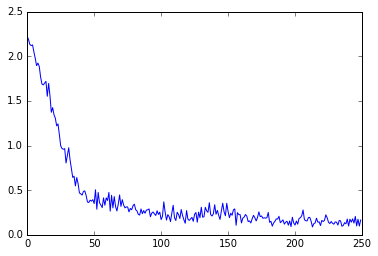

In [14]:
plt.plot(losses)

In [15]:
for t in range(2):
    X_test, y_test = pull_batch(batch_size)
    X_test_str = ["".join(vocab.indices2words(sentence)) for sentence in X_test.T]
    
    feed_dict = {X[t]: X_test[t] for t in range(seq_length)}
    feed_dict[y] = y_test
    
    y_pred_test = sess.run(tf.argmax(logits, 1), feed_dict)
    for sentence, y_obs, y_pred in zip(X_test_str, y_test, y_pred_test):
        if y_obs == y_pred: continue
        print "%s %s %s" % (files[y_obs][5:8], files[y_pred][5:8], sentence)

afr dan Zover het oog reikt heerst hier het moment.       
bcl afr ” (2 Nephi 26:33).                                
eng bcl "Abigail regularly sits up in a chair for short pe
ces afr Jaderna elektrarna Temelin je pro 60% obyvatel CR 
deu dan Elektronikbranche hofft auf Funkausstellung (dpa).
deu eng Welches Bild von Deutschland hatten Sie, als Sie i
als eng Ne 1941, bashke me Francesco Leonetti, Roberto Rov
deu afr Der ZEIT sagte er in einem Interview im vorigen Ja
dan eng TILMELDING & BETALING : Skal ske til Morten el.   
deu afr Der Vorgang lasse "die Inquisition wie eine Studie
bcl afr HOROPHOROPA :Horophoropa man baya O neneng ko :ta 
deu dan Trost bietet da der Kofferraum, den man besser als
dan afr Komponist workshop med Esbjerg Ensemble.          
deu afr Ohne Qualifikationssieg bei der EM 1996 in Vejle d
deu afr Dieser 'Poet im vollen Sinne des Worts', das freil
deu afr Es ist die "National Rifle Association" (NRA), die
dan afr 53: De syv urskiver (The Seven Dails Mystery